*고래, 거래소 주소 가져오기*

In [1]:
import requests
from bs4 import BeautifulSoup

def get_addresses_from_page(page_num):
    url = f"https://bitinfocharts.com/top-100-richest-bitcoin-addresses-{page_num}.html" if page_num > 1 else "https://bitinfocharts.com/top-100-richest-bitcoin-addresses.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Remove hidden-desktop spans
    for span in soup.find_all('span', class_='hidden-desktop'):
        span.decompose()

    whale_addresses = []
    exchange_addresses = []
    combined_addresses = []

    # 숫자가 없는 경우를 확인하는 함수
    def no_digits(s):
        return all(not c.isdigit() for c in s)
    
    if page_num > 1:
        i = 0
    else:
        i = 16

    for row in soup.find_all('tr')[i:]:
        cols = row.find_all('td')
        if len(cols) > 1:
            address = cols[1].text.strip().split('wallet')[0].split(' ')[0]
            balance = float(cols[2].text.strip().replace(',', '').split(' ')[0])
            label = cols[1].text.strip().split(':')

            if balance >= 1000:
                whale_addresses.append(address)

            if 'wallet' in label[0]:
                label_text = label[1].strip().split()[0]  # 불필요한 정보 제거
                if no_digits(label_text):
                    exchange_addresses.append(address)

    for address in whale_addresses:
        if address in exchange_addresses:
            combined_addresses.append(address)
    
    # Remove combined addresses from both lists
    whale_addresses = [addr for addr in whale_addresses if addr not in combined_addresses]

    return whale_addresses, exchange_addresses, combined_addresses

# ✅ 1~10페이지 크롤링
all_whale_addresses = []
all_exchange_addresses = []
all_combined_addresses = []

for page in range(1, 11):
    whale, exchange, combined = get_addresses_from_page(page)
    all_whale_addresses.extend(whale)
    all_exchange_addresses.extend(exchange)
    all_combined_addresses.extend(combined)

# ✅ 결과 출력
print("🐳 Whale Addresses:", all_whale_addresses)
print("🏦 Exchange Addresses:", all_exchange_addresses)


🐳 Whale Addresses: ['bc1q8yj0herd4r4yxszw3nkfvt53433thk0f5qst4g', '1Ay8vMC7R1UbyCCZRVULMV7iQpHSAbguJP', 'bc1qd4ysezhmypwty5dnw7c8nqy5h5nxg0xqsvaefd0qn5kq32vwnwqqgv4rzr', '1LdRcdxfbSnmCYYNdeYpUnztiYzVfBEQeC', '1AC4fMwgY8j9onSbXEWeH6Zan8QGMSdmtA', 'bc1qcardnx2pjnh0ce0rsdkce2yxxr9v6pt9a6qya3', 'bc1qa2eu6p5rl9255e3xz7fcgm6snn4wl5kdfh7zpt05qp5fad9dmsys0qjg0e', '1LruNZjwamWJXThX2Y8C2d47QqhAkkc5os', 'bc1qxu4nfkdf8a97mey8ke3npg3aggvskvvcdgndnvxn5upv7jypxdgs3mhvvy', 'bc1q8taf2eca7pn9wu4czt8fgftqm288xtfxdyt33syzxuexxty733xsszghzk', 'bc1qzwhw94uldd3c8736lsxrda6t6x56030f8zk8nr', '12XqeqZRVkBDgmPLVY4ZC6Y4ruUUEug8Fx', '12ib7dApVFvg82TXKycWBNpN8kFyiAN1dr', '12tkqA9xSoowkzoERHMWNKsTey55YEBqkv', 'bc1q7uq3u829ahn22sdlpac0h0lurq3a9yfd3ew69f', '3EMVdMehEq5SFipQ5UfbsfMsH223sSz9A9', '39eYrpgAgDhp4tTjrSb1ppZ5kdAc1ikBYw', '17MWdxfjPYP2PYhdy885QtihfbW181r1rn', '1N7jWmv63mkMdsYzbNUVHbEYDQfcq1u8Yp', '19D5J8c59P2bAkWKvxSYw8scD3KUNWoZ1C', '15cHRgVrGKz7qp2JL2N5mkB2MCFGLcnHxv', '3HfD4pvF43jdu9dzVMEr1b8AnDHooRGc5t', 

**거래소 주소 트랜잭션 가져옴**

In [2]:
import requests
import datetime
import pandas as pd
import time

# 🔹 모든 데이터를 저장할 리스트
data = []

def get_transactions_mempool(address, after_txid=None, max_retries=3):
    """거래소 주소의 트랜잭션 데이터를 가져옴 (자동 재시도 포함)"""
    url = f"https://mempool.space/api/address/{address}/txs"
    if after_txid:
        url += f"?after_txid={after_txid}"

    for attempt in range(max_retries):  # ✅ 최대 3회 재시도
        try:
            response = requests.get(url, timeout=10, stream=True)  # ✅ `stream=True` 추가
            response.raise_for_status()  # ✅ HTTP 오류 발생 시 예외 발생
            return response.json()
        
        except requests.exceptions.ChunkedEncodingError:
            print(f"⚠️ ChunkedEncodingError 발생. {attempt + 1}/{max_retries}회 재시도 중...")
            time.sleep(3)  # ✅ 재시도 전 3초 대기
        
        except requests.exceptions.RequestException as e:
            print(f"❌ 요청 오류 발생: {e}")
            break  # ✅ 다른 요청 오류 발생 시 중단
    
    return []  # ✅ 모든 재시도 실패 시 빈 리스트 반환

def process_transactions(address, max_transactions=500):
    """거래소 지갑의 트랜잭션 데이터를 분석"""
    transactions = []
    after_txid = None  

    while len(transactions) < max_transactions:
        batch = get_transactions_mempool(address, after_txid)
        
        if not batch:
            break  # ✅ 더 이상 가져올 트랜잭션이 없으면 종료
        
        transactions.extend(batch)
        after_txid = batch[-1]['txid']  # ✅ 가장 오래된 트랜잭션 ID 저장
        
        time.sleep(1)  # ✅ API 요청 속도 제한 고려 (1초 대기)

    for tx in transactions[:max_transactions]:  
        sent_amount = 0
        received_amount = 0
        
        for vin in tx['vin']:
            if vin.get('prevout') and 'scriptpubkey_address' in vin['prevout']:
                if vin['prevout']['scriptpubkey_address'] == address:
                    sent_amount += vin['prevout']['value']  

        for vout in tx['vout']:
            if 'scriptpubkey_address' in vout:
                if vout['scriptpubkey_address'] == address:
                    received_amount += vout['value']  

        date = datetime.datetime.fromtimestamp(tx['status']['block_time']).strftime('%Y-%m-%d') if 'block_time' in tx['status'] else "Unconfirmed"

        data.append({
            "date": date,
            "wallet_address": address,
            "sent_amount_btc": sent_amount / 1e8,  
            "received_amount_btc": received_amount / 1e8  
        })

# 🔹 거래소 주소 목록 처리
for addr in all_exchange_addresses:
    process_transactions(addr, max_transactions=1000)  

df_exchange_transactions = pd.DataFrame(data)
df_exchange_transactions.sort_values(by='date', inplace=True)
print(df_exchange_transactions.head(10))

            date                      wallet_address  sent_amount_btc  \
3032  2011-03-01  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3031  2011-06-04  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3030  2012-06-23  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3029  2012-07-16  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3028  2012-10-23  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3027  2013-01-26  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3026  2013-04-09  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3025  2013-06-24  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3024  2013-06-30  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   
3023  2013-07-27  1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF              0.0   

      received_amount_btc  
3032         7.995600e+04  
3031         1.000000e-03  
3030         3.133700e-02  
3029         9.990000e-01  
3028         9.763000e-03  
3027         1.000000e-03  


Unconfirmed 제거

In [3]:
for i in range(len(df_exchange_transactions.index)):
    if df_exchange_transactions.loc[i, 'date'] == 'Unconfirmed':
        df_exchange_transactions.drop(index=[i], inplace=True)
df_exchange_transactions

,date,wallet_address,sent_amount_btc,received_amount_btc
3032,2011-03-01,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000000,79956.000000
3031,2011-06-04,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000000,0.001000
3030,2012-06-23,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000000,0.031337
3029,2012-07-16,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000000,0.999000
3028,2012-10-23,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,0.000000,0.009763
...,...,...,...,...
13070,2025-03-19,bc1qcv8h9hp5w8c4qpze0a4tdxw6qjtvg8yps23k0g3aym...,0.000000,64.716706
17283,2025-03-19,1GrwDkr33gT6LuumniYjKEGjTLhsL5kmqC,21.415214,20.945864
17284,2025-03-19,1GrwDkr33gT6LuumniYjKEGjTLhsL5kmqC,21.886488,12.044729
17268,2025-03-19,1GrwDkr33gT6LuumniYjKEGjTLhsL5kmqC,0.000000,0.739199


상위 10개 입금의 비중(Whale exchange ratio)

In [4]:
def calculate_whale_ratio(df, start_date, end_date):
    whale_ratios = {}
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    for single_date in date_range:
        date_str = single_date.strftime('%Y-%m-%d')
        all_deposits = []
        for index, row in df.iterrows():
            if row['date'] == date_str:
                received_amount = row['sent_amount_btc']
                all_deposits.append(received_amount)
        all_deposits.sort(reverse=True)
        if len(all_deposits) >= 11:
            top_10_sum = sum(all_deposits[:10])
            total_sum = sum(all_deposits)
            whale_ratio = top_10_sum / total_sum if total_sum > 0 else 0
            whale_ratios[date_str] = whale_ratio
    return whale_ratios

# 예제 사용법
whale_ratios = calculate_whale_ratio(df_exchange_transactions, '2022-01-01', '2025-03-18')
whale_ratios

{'2022-02-01': 0,
 '2022-06-17': 1.0,
 '2022-08-12': 1.0,
 '2022-09-30': 1.0,
 '2022-10-24': 1.0,
 '2022-11-10': 1.0,
 '2022-11-12': 1.0,
 '2022-12-23': 1.0,
 '2023-01-17': 1.0,
 '2023-02-14': 1.0,
 '2023-02-16': 1.0,
 '2023-03-22': 1.0,
 '2023-03-24': 1.0,
 '2023-04-04': 1.0,
 '2023-04-05': 1.0,
 '2023-04-06': 1.0,
 '2023-04-12': 1.0,
 '2023-04-18': 1.0,
 '2023-04-21': 1.0,
 '2023-04-23': 0,
 '2023-04-24': 1.0,
 '2023-04-27': 1.0,
 '2023-05-02': 1.0,
 '2023-05-03': 0.9999999826875628,
 '2023-05-08': 1.0,
 '2023-05-09': 1.0,
 '2023-05-11': 1.0,
 '2023-05-17': 1.0,
 '2023-05-24': 1.0,
 '2023-05-25': 0,
 '2023-05-26': 1.0,
 '2023-06-02': 1.0,
 '2023-06-05': 0,
 '2023-06-07': 1.0,
 '2023-06-08': 1.0,
 '2023-06-14': 1.0,
 '2023-06-15': 1.0,
 '2023-06-16': 1.0,
 '2023-06-17': 1.0,
 '2023-06-19': 1.0,
 '2023-06-20': 1.0,
 '2023-06-21': 1.0,
 '2023-06-22': 1.0,
 '2023-06-23': 1.0,
 '2023-06-24': 1.0,
 '2023-06-27': 1.0,
 '2023-06-28': 0,
 '2023-06-29': 1.0,
 '2023-06-30': 1.0,
 '2023-07-01': 

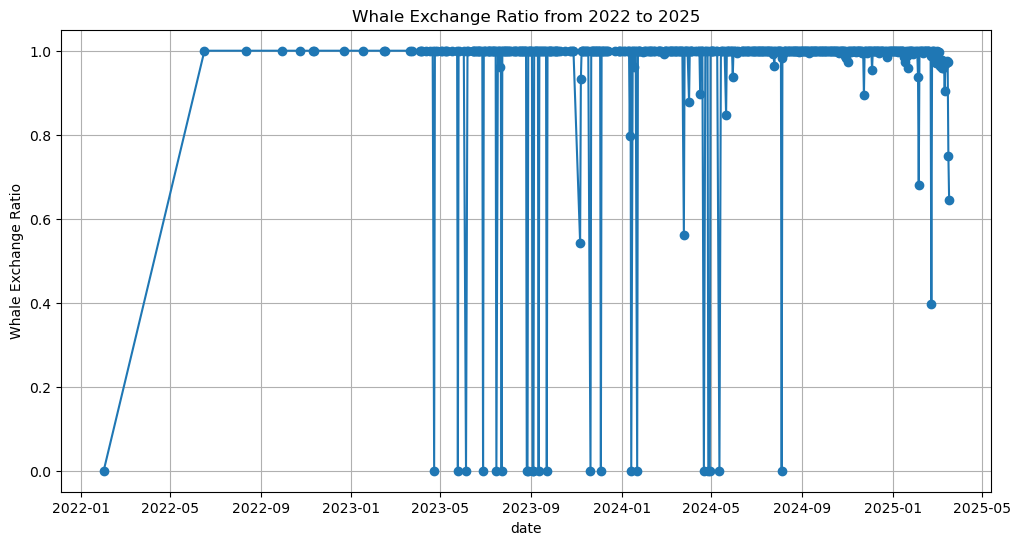

In [5]:
import matplotlib.pyplot as plt

# 데이터프레임으로 변환
df_whale_ratios = pd.DataFrame(list(whale_ratios.items()), columns=['date', 'Whale Ratio'])
df_whale_ratios['date'] = pd.to_datetime(df_whale_ratios['date'])
df_whale_ratios.set_index('date', inplace=True)
df_whale_ratios.to_csv('whale_exchange_ratio.csv')

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_whale_ratios.index, df_whale_ratios['Whale Ratio'], marker='o', linestyle='-')
plt.title('Whale Exchange Ratio from 2022 to 2025')
plt.xlabel('date')
plt.ylabel('Whale Exchange Ratio')
plt.grid(True)
plt.show()

In [6]:
df_exchange_transactions.to_csv('cex_transactions.csv')

In [7]:
# 🔹 날짜별 총 입금량 및 출금량 계산
df_daily_summary = df_exchange_transactions.groupby("date", as_index=False).agg({
    "sent_amount_btc": "sum",
    "received_amount_btc": "sum"
})

# ✅ 결과 출력
print(df_daily_summary)

            date  sent_amount_btc  received_amount_btc
0     2011-03-01         0.000000         79956.000000
1     2011-06-04         0.000000             0.001000
2     2012-06-23         0.000000             0.031337
3     2012-07-16         0.000000             0.999000
4     2012-10-23         0.000000             0.009763
...          ...              ...                  ...
2019  2025-03-14     48222.212088         48594.335934
2020  2025-03-15     40034.584864         41442.782000
2021  2025-03-16     94395.979258         94388.635853
2022  2025-03-17    121517.418970        121011.606347
2023  2025-03-18    118085.683679        116624.712089

[2024 rows x 3 columns]
